# DE300 HW1 - Nicky Williams

In [2]:
import pandas as pd
inventory = pd.read_csv('/content/T_F41SCHEDULE_B43.csv')
# inventory.head()

<ipython-input-2-1067a66527ff>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('/content/T_F41SCHEDULE_B43.csv')


1. Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible. Give your reasoning and code if you decide to impute missing values.
- Columns for investigation: CARRIER, CARRIER_NAME, MANUFACTURE_YEAR, NUMBER_OF_SEATS, CAPACITY_IN_POUNDS, and AIRLINE_ID.
- For example, watch out for "North American Airlines" aircrafts. Are the CARRIER/UNIQUE_CARRIER column really missing?

In [12]:
# Inspecting missing values in given columns
cols_to_check = ['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
                 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']
missing_summary = inventory[cols_to_check].isnull().sum()
print("Missing values in each column:")
print(missing_summary)

Missing values in each column:
CARRIER               0
CARRIER_NAME          0
MANUFACTURE_YEAR      0
NUMBER_OF_SEATS       0
CAPACITY_IN_POUNDS    0
AIRLINE_ID            0
dtype: int64


<Axes: >

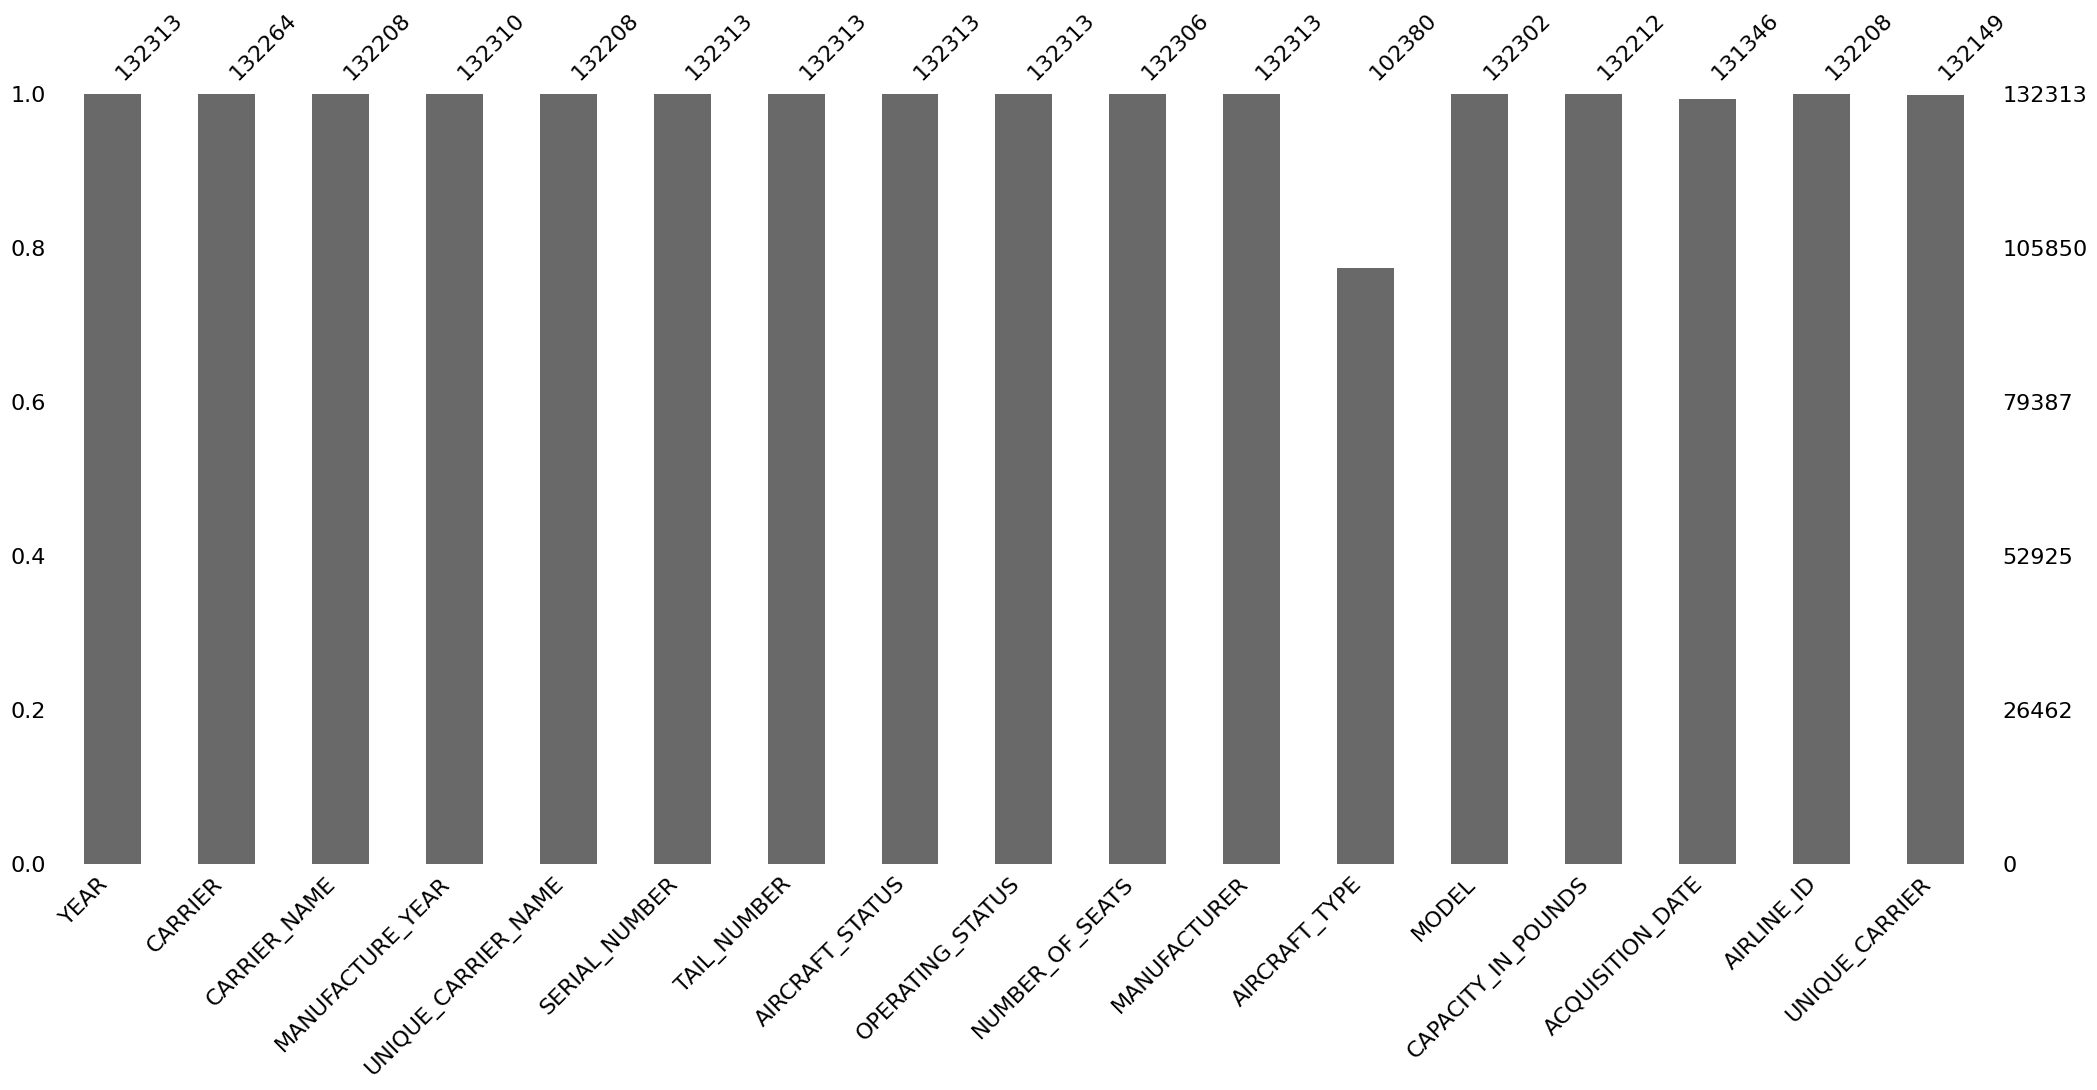

In [4]:
import missingno as msno
msno.bar(inventory)

In [5]:
# Note that the "NA" in the North American Airlines aircrafts should not be handled
# as missing columns but rather as a just poor choice of a shorthand notation for carrier identification


# Impute carrier using carrier_name because they have a one-to-one relationship with one another
carrier_mapping = inventory[['CARRIER', 'CARRIER_NAME']].dropna().drop_duplicates()
name_to_carrier = dict(zip(carrier_mapping['CARRIER_NAME'], carrier_mapping['CARRIER']))
inventory['CARRIER'] = inventory.apply(
    lambda row: name_to_carrier.get(row['CARRIER_NAME'], row['CARRIER']) if pd.isna(row['CARRIER']) else row['CARRIER'],
    axis=1
)

# Impute carrier_name using carrier (same logic as above)
code_to_name = dict(zip(carrier_mapping['CARRIER'], carrier_mapping['CARRIER_NAME']))
inventory['CARRIER_NAME'] = inventory.apply(
    lambda row: code_to_name.get(row['CARRIER'], row['CARRIER_NAME']) if pd.isna(row['CARRIER_NAME']) else row['CARRIER_NAME'],
    axis=1
)

# Impute manufactor_year using model because the manuf. year is usually the same
# across the same aircraft models minus a few outliers (hence using median)
# Fill any remaining missing values with the median value of the column
inventory['MANUFACTURE_YEAR'] = inventory.groupby('MODEL')['MANUFACTURE_YEAR'].transform(
    lambda x: x.fillna(x.median())
)
inventory['MANUFACTURE_YEAR'] = inventory['MANUFACTURE_YEAR'].fillna(inventory['MANUFACTURE_YEAR'].median())

# Impute number_of_seats using model (same logic as above)
inventory['NUMBER_OF_SEATS'] = inventory.groupby('MODEL')['NUMBER_OF_SEATS'].transform(
    lambda x: x.fillna(x.median())
)
inventory['NUMBER_OF_SEATS'] = inventory['NUMBER_OF_SEATS'].fillna(inventory['NUMBER_OF_SEATS'].median())

# Impute capacity_in_pounds using model (same logic as above)
inventory['CAPACITY_IN_POUNDS'] = inventory.groupby('MODEL')['CAPACITY_IN_POUNDS'].transform(
    lambda x: x.fillna(x.median())
)
inventory['CAPACITY_IN_POUNDS'] = inventory['CAPACITY_IN_POUNDS'].fillna(inventory['CAPACITY_IN_POUNDS'].median())

# Impute airline_id using carrier because they have a one-to-one relationship with one another
airline_map = inventory[['CARRIER', 'AIRLINE_ID']].dropna().drop_duplicates()
carrier_to_id = dict(zip(airline_map['CARRIER'], airline_map['AIRLINE_ID']))
inventory['AIRLINE_ID'] = inventory.apply(
    lambda row: carrier_to_id.get(row['CARRIER'], row['AIRLINE_ID']) if pd.isna(row['AIRLINE_ID']) else row['AIRLINE_ID'],
    axis=1
)

# Check
print("Final missing values:")
print(inventory[['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
                 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']].isnull().sum())


Final missing values:
CARRIER               0
CARRIER_NAME          0
MANUFACTURE_YEAR      0
NUMBER_OF_SEATS       0
CAPACITY_IN_POUNDS    0
AIRLINE_ID            0
dtype: int64


2. Inspect the columns MANUFACTURER, MODEL, AIRCRAFT_STATUS, and OPERATING_STATUS. Decide, for each column, if transformation or standardization of data are required. Give your reasoning and code if you decide to transform the data.
**Hints:**
- For very messy data like manufacturer/model names, give your best attempt. It is okay to not catch them all.
- Use value_counts() to identify "big wins".
- Break down into multiple steps, instead of having one line of code to do them all.

The manufacturer column needs standardization because it has several variations for the same company due to inconsistent capitalization, spacing, and naming conventions (BOEING/THEBOEINGCO/BoeingCo/THEBOEINGCOMPANY, etc).

The model column *may* need standardization depending on how exact the models are or if letters/words can be included in the model id.

The aircraft_status and operating_status columns have discrepancies in capitalization and need standardization for that.

In [6]:
for col in ['MANUFACTURER', 'MODEL', 'AIRCRAFT_STATUS', 'OPERATING_STATUS']:
    print(f"\nUnique values in {col}:")
    print(inventory[col].value_counts(dropna=False).head(20))



Unique values in MANUFACTURER:
MANUFACTURER
BOEING                                                                              15922
Embraer                                                                             11508
THEBOEINGCO                                                                          9223
Bombardier                                                                           8871
Boeing                                                                               8392
BoeingCo                                                                             7446
AIRBUS                                                                               7179
AirbusIndustries                                                                     6967
BOEINGCOMPANY                                                                        6767
Airbus                                                                               5289
CESSNA                                                 

In [7]:
import numpy as np

# 1. Manufacturer col

# Standardizing whitespace and casing
inventory['MANUFACTURER'] = inventory['MANUFACTURER'].str.strip().str.upper()

# Mapping common variations of "Boeing" to standardized names
manufacturer_map = {
    "BOEING": "BOEING",
    "THEBOEINGCO": "BOEING",
    "BOEINGCO": "BOEING",
    "BOEINGCOMPANY": "BOEING",
    "THEBOEINGCOMPANY": "BOEING",
    "THEBOEINGCOMPANY": "BOEING",
    "THEBOEING": "BOEING",
    "THEBOEING CO": "BOEING",
    "THEBOEINGCOMP": "BOEING",
    "THEBOEING COMPANY": "BOEING",
    "THEBOEINGCOMPANY": "BOEING",
    "THEBOEINGCO": "BOEING",
    "THEBOEINGCOMP": "BOEING",
    "BOEING COMPANY": "BOEING",
    "AIRBUS": "AIRBUS",
    "AIRBUSINDUSTRIES": "AIRBUS",
    "AIRBUSINDUSTRIE": "AIRBUS",
    "EMBRAER": "EMBRAER",
    "BOMBARDIER": "BOMBARDIER",
    "CESSNA": "CESSNA",
    "MCDONNELL-DOUGLAS": "MCDONNELL DOUGLAS",
    "MCDONNELLDOUGLAS": "MCDONNELL DOUGLAS"
}

inventory['MANUFACTURER'] = inventory['MANUFACTURER'].replace(manufacturer_map)


# 2. Model col

# Standardizing spacing and casing
inventory['MODEL'] = inventory['MODEL'].str.strip().str.upper()

# Some obvious variants
model_map = {
    "737-700PASSENGERONLY": "737-700",
    "SUPER80PASSENGER": "MD-80",
    "B737-800PAX": "B737-800",
    "CRJ200-2B19": "CRJ-200",
    "CRJ-2/4": "CRJ-200",
    "A320-1/2": "A320"
}

inventory['MODEL'] = inventory['MODEL'].replace(model_map)


# Aircraft_status col
# Standardize casing
inventory['AIRCRAFT_STATUS'] = inventory['AIRCRAFT_STATUS'].str.upper()


# Operating_status col
# Standardize casing
inventory['OPERATING_STATUS'] = inventory['OPERATING_STATUS'].str.upper()
# Treat empty strings or whitespace-only as missing
inventory['OPERATING_STATUS'] = inventory['OPERATING_STATUS'].replace(r'^\s*$', np.nan, regex=True)


In [8]:
# Checking
print("Unique cleaned values:")
print("\nMANUFACTURER:", inventory['MANUFACTURER'].value_counts().head())
print("\nMODEL:", inventory['MODEL'].value_counts().head())
print("\nAIRCRAFT_STATUS:", inventory['AIRCRAFT_STATUS'].value_counts())
print("\nOPERATING_STATUS:", inventory['OPERATING_STATUS'].value_counts(dropna=False))

Unique cleaned values:

MANUFACTURER: MANUFACTURER
BOEING               54933
AIRBUS               23159
EMBRAER              15554
BOMBARDIER           11834
MCDONNELL DOUGLAS     8465
Name: count, dtype: int64

MODEL: MODEL
CRJ-200      4251
EMB-145      2976
MD-80        2718
B-737-7H4    2470
B737-823     2370
Name: count, dtype: int64

AIRCRAFT_STATUS: AIRCRAFT_STATUS
O    79506
B    43551
A     9134
L      122
Name: count, dtype: int64

OPERATING_STATUS: OPERATING_STATUS
Y      126648
N        5664
NaN         1
Name: count, dtype: int64


3. Remove data rows that still have missing values. Report the amount of remaining data you obtained.


In [9]:
# Dropping rows w/ any remaining missing values and printting the result
inventory_cleaned = inventory.dropna()
print(f"Number of rows after dropping missing values: {inventory_cleaned.shape[0]}")


Number of rows after dropping missing values: 101275


4. Transformation and derivative variables
- For the columns NUMBER_OF_SEATS and CAPACITY_IN_POUNDS, check the skewness in the variable and plot a histogram for each variable.
- The Box-Cox transformation (scipy.stats.boxcox) is one possible way to transform variables into a "more-normal-like" variable. Apply the Box-Cox transformation for these two columns and save them as new columns, i.e. XXXXXXXXX_BOXCOX.
- Plot a histogram for each transformed variable.
- Describe what you observe before and after transformation.

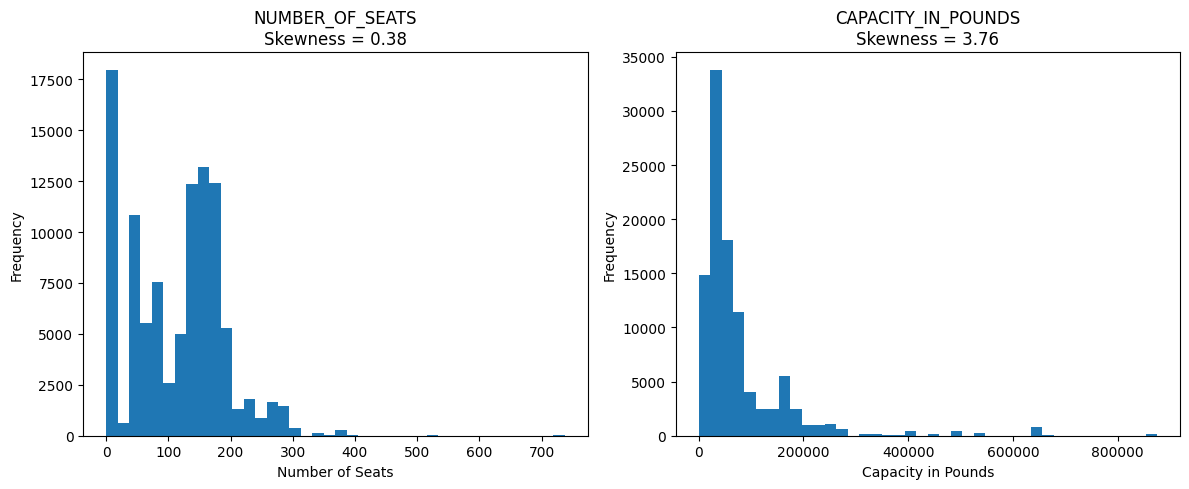

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import skew

# Calculating skewness
seats_skew = skew(inventory_cleaned['NUMBER_OF_SEATS'])
capacity_skew = skew(inventory_cleaned['CAPACITY_IN_POUNDS'])

# Plotting histograms
plt.figure(figsize=(12, 5))

# Number_of_seats
plt.subplot(1, 2, 1)
plt.hist(inventory_cleaned['NUMBER_OF_SEATS'], bins=40)
plt.title(f'NUMBER_OF_SEATS\nSkewness = {seats_skew:.2f}')
plt.xlabel('Number of Seats')
plt.ylabel('Frequency')

# Capacity_in_pounds
plt.subplot(1, 2, 2)
plt.hist(inventory_cleaned['CAPACITY_IN_POUNDS'], bins=40)
plt.title(f'CAPACITY_IN_POUNDS\nSkewness = {capacity_skew:.2f}')
plt.xlabel('Capacity in Pounds')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [31]:
from scipy.stats import boxcox

inventory_cleaned = inventory.dropna().copy()

# Using only rows that are positive since Box-Cox requires > 0
positive_seats = inventory_cleaned['NUMBER_OF_SEATS'] > 0
positive_capacity = inventory_cleaned['CAPACITY_IN_POUNDS'] > 0
valid_rows = positive_seats & positive_capacity

# Box-Cox
seats_boxcox, seats_lambda = boxcox(inventory_cleaned.loc[valid_rows, 'NUMBER_OF_SEATS'])
capacity_boxcox, capacity_lambda = boxcox(inventory_cleaned.loc[valid_rows, 'CAPACITY_IN_POUNDS'])

# Storing into new cols
inventory_cleaned.loc[valid_rows, 'NUMBER_OF_SEATS_BOXCOX'] = seats_boxcox
inventory_cleaned.loc[valid_rows, 'CAPACITY_IN_POUNDS_BOXCOX'] = capacity_boxcox

# Printting lambdas
print(f"Box-Cox lambda for NUMBER_OF_SEATS: {seats_lambda:.4f}")
print(f"Box-Cox lambda for CAPACITY_IN_POUNDS: {capacity_lambda:.4f}")


Box-Cox lambda for NUMBER_OF_SEATS: 0.6392
Box-Cox lambda for CAPACITY_IN_POUNDS: 0.0575


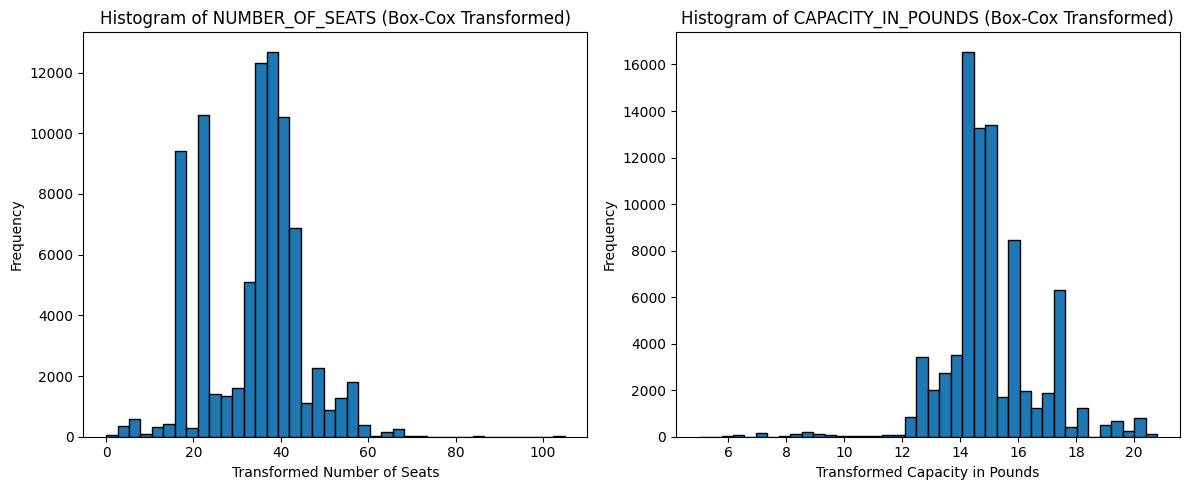

In [33]:
import matplotlib.pyplot as plt


# Creatting histograms
plt.figure(figsize=(12, 5))


# Number_of_seats_boxcox
plt.subplot(1, 2, 1)
plt.hist(inventory_cleaned['NUMBER_OF_SEATS_BOXCOX'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of NUMBER_OF_SEATS (Box-Cox Transformed)')
plt.xlabel('Transformed Number of Seats')
plt.y

# Capacity_in_pounds_boxcox
plt.subplot(1, 2, 2)
plt.hist(inventory_cleaned['CAPACITY_IN_POUNDS_BOXCOX'].dropna(), bins=40, edgecolor='black')
plt.title('Histogram of CAPACITY_IN_POUNDS (Box-Cox Transformed)')
plt.xlabel('Transformed Capacity in Pounds')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Before the Box-Cox transformation, both columns showed strong right-skewed distributions.

Number_of_seats was slightly more moderate, with most aircraft clustering around 50-200 seats and a few outliers with a large number of seats stretching the right tail of the distribution.

Capacity_in_pounds was very right-skewed, with an even smaller number of outliers (likely cargo planes).

 After the Box-Cox transformation, both variables became  more symmetric and closer to a normal distribution.

5. Feature engineering
- Create a new column SIZE by the quartiles of NUMBER_OF_SEATS
  - below 25% percentile: SMALL
  - 25% - 50% percentile: MEDIUM
  - 50% - 75% percentile: LARGE
  - above 75% percentile: XLARGE
- For each size group, provide and plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS).
- For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS).
- Provide a written summary of your findings.

In [34]:
# Quantiles
q1 = inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.25)
q2 = inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.50)
q3 = inventory_cleaned['NUMBER_OF_SEATS'].quantile(0.75)

def assign_size(seats):
    if seats < q1:
        return 'SMALL'
    elif seats < q2:
        return 'MEDIUM'
    elif seats < q3:
        return 'LARGE'
    else:
        return 'XLARGE'

# Creatting new col
inventory_cleaned['SIZE'] = inventory_cleaned['NUMBER_OF_SEATS'].apply(assign_size)
inventory_cleaned[['NUMBER_OF_SEATS', 'SIZE']].head()


,NUMBER_OF_SEATS,SIZE
29239,92.0,MEDIUM
29240,86.0,MEDIUM
29241,86.0,MEDIUM
29242,136.0,MEDIUM
29243,19.0,SMALL


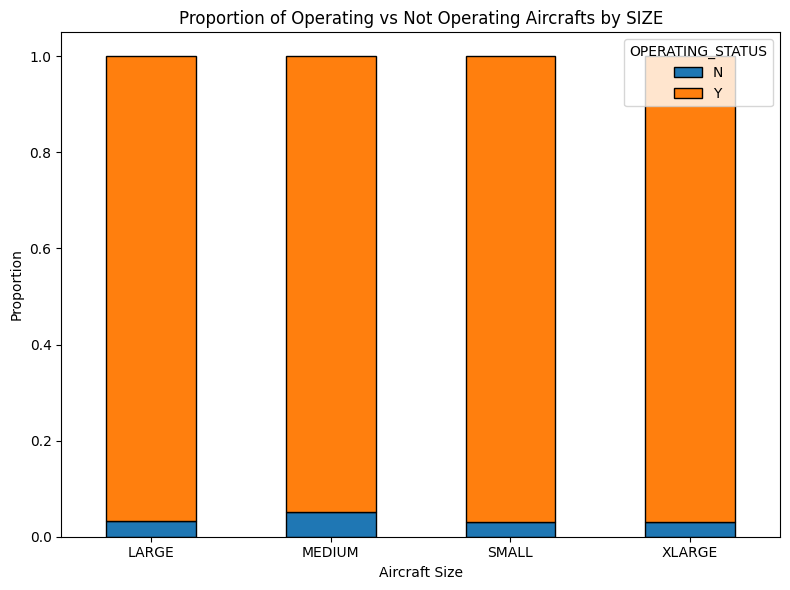

OPERATING_STATUS         N         Y
SIZE                                
LARGE             0.033143  0.966857
MEDIUM            0.052408  0.947592
SMALL             0.031002  0.968998
XLARGE            0.030592  0.969408


In [35]:
import matplotlib.pyplot as plt

# Groupping by size and operating_staus
operating_summary = (
    inventory_cleaned.groupby(['SIZE', 'OPERATING_STATUS'])
    .size()
    .unstack(fill_value=0)
)

# Converting to proportions
operating_proportions = operating_summary.div(operating_summary.sum(axis=1), axis=0)

# Plotting
operating_proportions.plot(kind='bar', stacked=True, figsize=(8, 6), edgecolor='black')
plt.title('Proportion of Operating vs Not Operating Aircrafts by SIZE')
plt.xlabel('Aircraft Size')
plt.ylabel('Proportion')
plt.legend(title='OPERATING_STATUS')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print(operating_proportions)


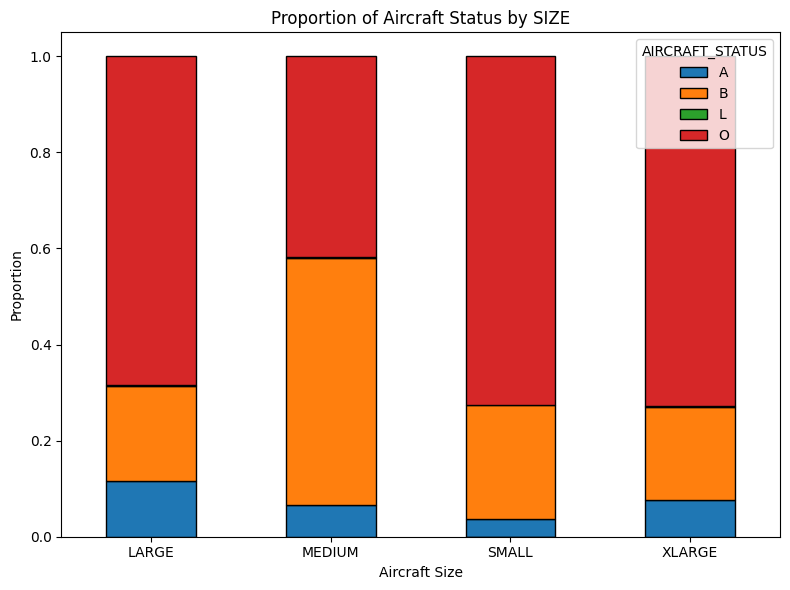

AIRCRAFT_STATUS         A         B         L         O
SIZE                                                   
LARGE            0.115702  0.197468  0.001746  0.685084
MEDIUM           0.065880  0.514826  0.001096  0.418198
SMALL            0.037909  0.235739  0.000000  0.726352
XLARGE           0.076263  0.193708  0.001732  0.728296


In [36]:
import matplotlib.pyplot as plt

# Groupping by size and aircraft_status
status_summary = (
    inventory_cleaned.groupby(['SIZE', 'AIRCRAFT_STATUS'])
    .size()
    .unstack(fill_value=0)
)

# Converting proportions
status_proportions = status_summary.div(status_summary.sum(axis=1), axis=0)

# Plotting
status_proportions.plot(kind='bar', stacked=True, figsize=(8, 6), edgecolor='black')

plt.title('Proportion of Aircraft Status by SIZE')
plt.xlabel('Aircraft Size')
plt.ylabel('Proportion')
plt.legend(title='AIRCRAFT_STATUS')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print(status_proportions)


From these plots we can first see that the majority of aircraft across all size groups fall under 'Y' operating status and the 'O' and 'B' aircraft status categories. Small, large, and extra-large aircrafts all had only about 3% of their aircrafts not operational, while medium aircrafts were slightly higher at 5%. This is interesting because it correlates to what we find in the aircraft status plot as well. Medium aircrafts had the lowest 'O' status and hihest 'B' status compared to the other sized aircrafts. This plot also seems to show a correlation between aircraft size and 'A' status, for as the planes get larger, the 'A' status frequency increases.